<a href="https://colab.research.google.com/github/AndreAmaral0802/real_state_funds_VS_SELIC/blob/main/ARIMA_US.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ARIMA for data series

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
dataset = pd.read_csv('drive/MyDrive/data_ARIMA.csv')

In [ ]:
dataset.head()

,observation_date,GDP
0,01/01/1981,3124206000
1,01/04/1981,3162532000
2,01/07/1981,3260609000
3,01/10/1981,3280818000
4,01/01/1982,3274302000


In [ ]:
# eliminate warnings 
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
import numpy as np


In [ ]:
dataset.dtypes

observation_date    object
GDP                  int64
dtype: object

In [ ]:
dataset.observation_date = pd.to_datetime(dataset.observation_date)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   observation_date  159 non-null    datetime64[ns]
 1   GDP               159 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.6 KB


In [ ]:
dataset.set_index('observation_date', inplace=True)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 159 entries, 1981-01-01 to 2020-01-07
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   GDP     159 non-null    int64
dtypes: int64(1)
memory usage: 2.5 KB


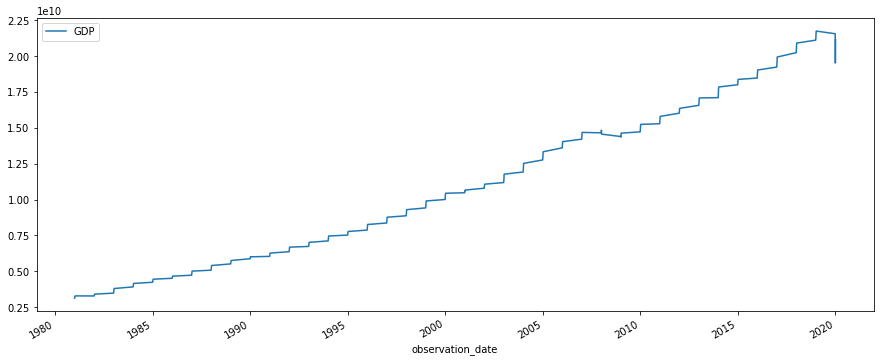

In [ ]:
dataset.plot(figsize=(15, 6))

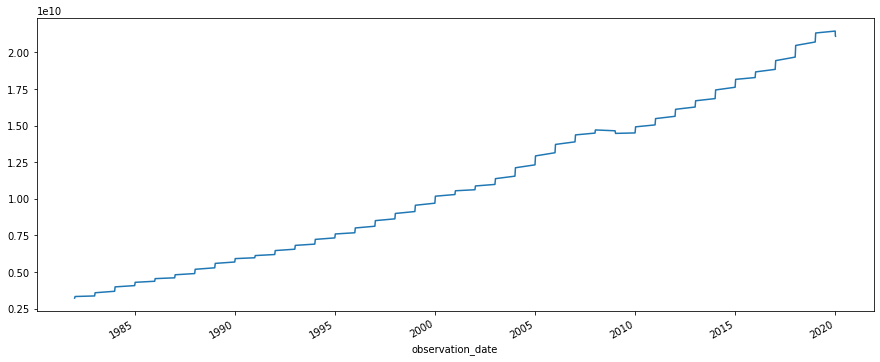

In [ ]:
dataset.GDP.rolling(5).mean().plot(figsize=(15, 6))

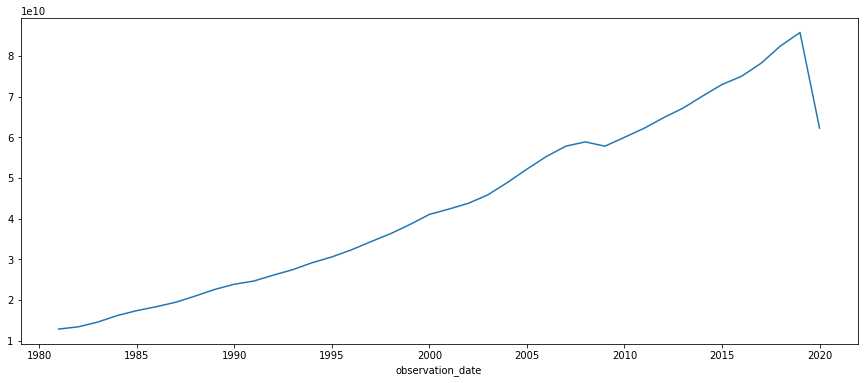

In [ ]:
dataset.GDP.groupby(dataset.index.year).sum().plot(figsize=(15, 6))

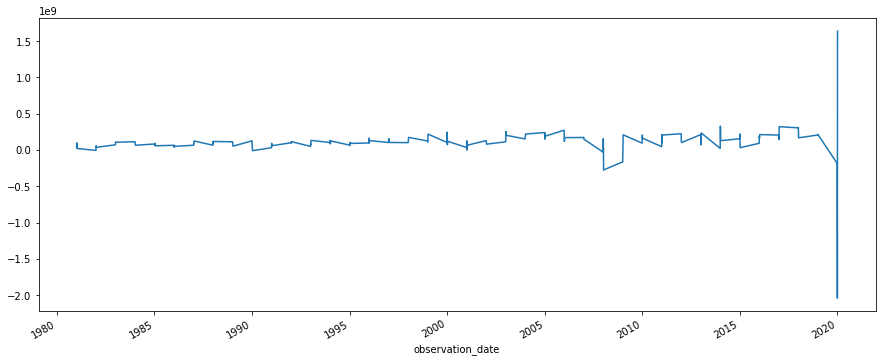

In [ ]:
dataset.GDP.diff().plot(figsize=(15, 6))

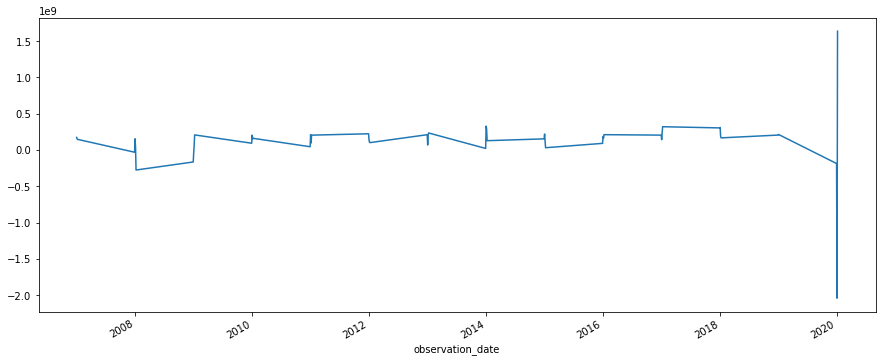

In [ ]:
# filter from 2010 to 2020
filter = (dataset.index.year >= 2007) & (dataset.index.year <= 2020)
dataset[filter].GDP.diff().plot(figsize=(15, 6))

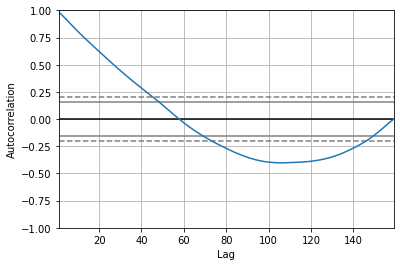

In [ ]:
# autocorrelation plot
autocorrelation_plot(dataset)
pyplot.show()

In [ ]:
pip install pandas 

In [ ]:
# another way of plotting autocorrelation
import pandas.util.testing as tm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

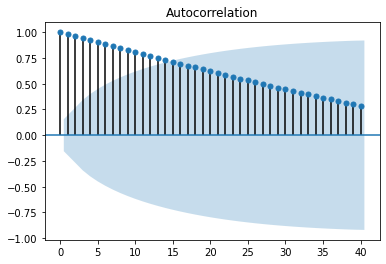

In [ ]:
plot_acf(dataset, lags=40)
pyplot.show()

In [ ]:
# fit the arima model
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

In [ ]:
# ARIMA (p, d, q)
model = ARIMA(dataset, order=(4,1,1))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
model_fit = model.fit()

In [ ]:
# summary
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.GDP   No. Observations:                  158
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -3253.625
Method:                       css-mle   S.D. of innovations      211027573.335
Date:                Wed, 30 Dec 2020   AIC                           6521.250
Time:                        10:46:37   BIC                           6542.688
Sample:                             1   HQIC                          6529.956
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.141e+08    7.2e+06     15.855      0.000       1e+08    1.28e+08
ar.L1.D.GDP     0.5840      0.103      5.662      0.000       0.382       0.786
ar.L2.D.GDP     0.4944      0.298      1.659    

In [ ]:
# plot residuals
from pandas import DataFrame
residuals = DataFrame (model_fit.resid)

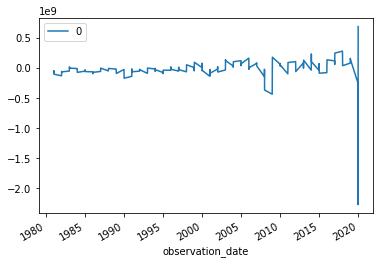

In [ ]:
residuals.plot()
pyplot.show()

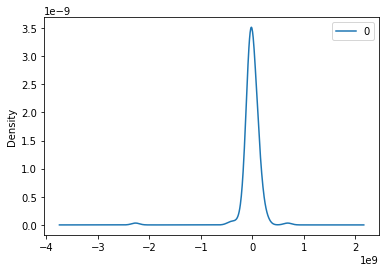

In [ ]:
# density graph - Gaussian
residuals.plot(kind='kde')
pyplot.show()

In [ ]:
print(residuals.describe())

                  0
count  1.580000e+02
mean  -1.503804e+07
std    2.117517e+08
min   -2.266738e+09
25%   -5.831380e+07
50%   -2.146158e+07
75%    5.514869e+07
max    6.858026e+08


In [ ]:
# variable x receives dataset
X = dataset.values
X = X.astype('float32')

In [ ]:
# separete the dataset
size = int(len(X)* 0.70)

In [ ]:
# separete training and testing
train = X[0:size]
test = X[size:]

In [ ]:
# create variable history
history = [x for x in train]

In [ ]:
# prediction list
predictions = list()

In [ ]:
# differencing function
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

# function that reverts the differecing value to original
def inverse_difference(history, predictions, interval=1):
  return predictions + history[-interval]

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

In [ ]:
# start walk-forward
for t in range(len(test)):

  # difference data
  quarters_per_year = 4
  diff = difference(history, quarters_per_year)

  # create arima model with history data
  model = ARIMA(diff, order=(1,1,1))

  # train ARIMA model
  model_fit = model.fit(trend='nc', disp=0)

  # variable predict_value receives the predicted value from the model
  predict_value = model_fit.forecast()[0]

  # predicted value receives the reverted value (original scale)
  predict_value = inverse_difference(history, predict_value, quarters_per_year)

  #adds the predicted values to the list of predictions
  predictions.append(predict_value)

  # variable real_value receives real value from the test
  real_value = test[t]

  # adds the real value to variable history
  history.append(real_value)

  # print predicted value e real value
  print('Predicted value=%.3f, Expected value=%3.f' % (predict_value, real_value))

Predicted value=14943962065.492, Expected value=14559543296
Predicted value=14357488324.483, Expected value=14394547200
Predicted value=14442101919.030, Expected value=14352849920
Predicted value=14258046695.408, Expected value=14420312064
Predicted value=14120673229.728, Expected value=14628021248
Predicted value=14653744561.299, Expected value=14721349632
Predicted value=14789411999.847, Expected value=14926098432
Predicted value=15118089027.077, Expected value=15079916544
Predicted value=15335486166.394, Expected value=15240843264
Predicted value=15314930842.514, Expected value=15285827584
Predicted value=15468056298.092, Expected value=15496188928
Predicted value=15651769620.381, Expected value=15591849984
Predicted value=15726721225.984, Expected value=15796459520
Predicted value=15859758700.325, Expected value=16019758080
Predicted value=16311758043.069, Expected value=16152256512
Predicted value=16217488234.385, Expected value=16257150976
Predicted value=16464223938.151, Expecte

In [ ]:
# Checking the results
from numpy import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 593416506.563


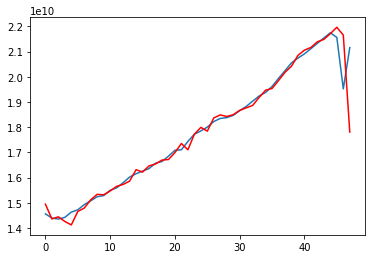

In [ ]:
# plot forecast against actual values
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
# testing the residuals against values
residuals = [test[i] - predictions[i] for i in range(len(test))]

In [ ]:
# convert the list into dataframe
residuals = pd.DataFrame(residuals)

In [ ]:
# residuals head
residuals.head()

,0
0,-3.844188e+08
1,3.705888e+07
2,-8.925200e+07
3,1.622654e+08
4,5.073480e+08


In [ ]:
residuals.describe()

,0
count,4.800000e+01
mean,2.687668e+07
std,5.990808e+08
min,-2.134343e+09
25%,-9.059972e+07
50%,1.531083e+07
75%,8.324756e+07
max,3.350070e+09


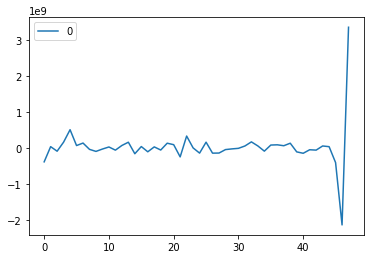

In [ ]:
residuals.plot()
pyplot.show()

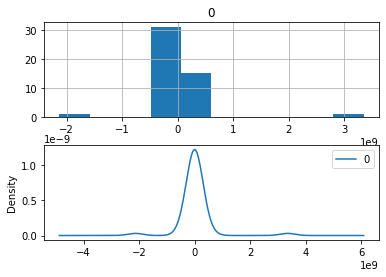

In [ ]:
# plot histogram
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())

pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

In [ ]:
# autocorrelation in the residuals
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

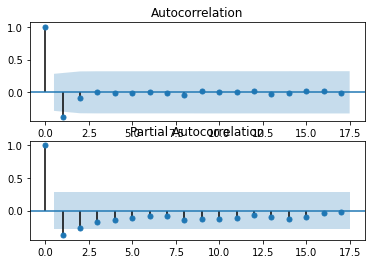

In [ ]:
# plot the autocorrelation
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, ax=pyplot.gca())
pyplot.show()

In [ ]:
model10=ARIMA(dataset['GDP'],order=(1,0,5))
model10=model10.fit

NameError: ignored

In [ ]:
from sklearn.metrics import r2_score
# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(test, predictions))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(test, predictions))

NameError: ignored

In [ ]:
print(dataset.describe())

                GDP
count  1.590000e+02
mean   1.096171e+10
std    5.487851e+09
min    3.124206e+09
25%    6.025147e+09
50%    1.043902e+10
75%    1.516038e+10
max    2.174739e+10
